# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.

В вашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные

In [3]:
directory = '/datasets/faces/final_files'  
csv_path = '/datasets/faces/labels.csv'  # CSV-файл с метками

# Загружаем таблицу
labels_df = pd.read_csv(csv_path)
labels_df['real_age'] = labels_df['real_age']
display(labels_df.head())
labels_df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Используем ImgageDataGenerator для подготовки данных

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255
)

overall_datagen = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=directory,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345
) 


Found 7591 validated image filenames.


Наша выборка состоит из 7591 изображения, которые представляют из себя 97 классов(то есть возрастов людей)

Посмотрим на распределение возраста среди покупателей

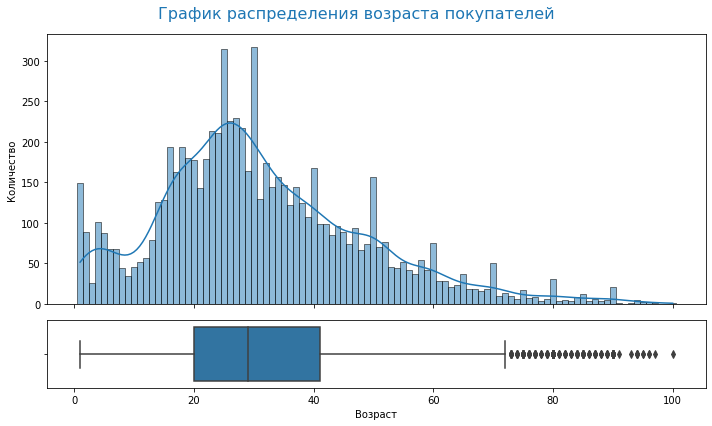

In [4]:
fig, (ax_main, ax_box) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}
)

fig.set_size_inches((10, 6))
sns.histplot(x=labels_df['real_age'].astype(int), kde=True, discrete=True, ax=ax_main).set(ylabel="Количество")
sns.boxplot(x=labels_df['real_age'].astype(int), ax=ax_box)
plt.suptitle("График распределения возраста покупателей", size=16, color="C0")
plt.xlabel("Возраст")
plt.tight_layout()
plt.show()

Из графиков можно сделать выводы, что:

- Большая часть людей находится в диапазоне 20-40 лет
- Люди старше 70 редко появляются в выборке, как и дети в возрасте 8-13 лет
- Присутствует больщой скачок в самом начале графика - большая разница в количестве подростков и детей
- Присутсвуют скачки(возможно, усреднённые значения возраста)
- Есть выбросы(людей старше 90 довольно мало)

Визуализируем несколько изображений

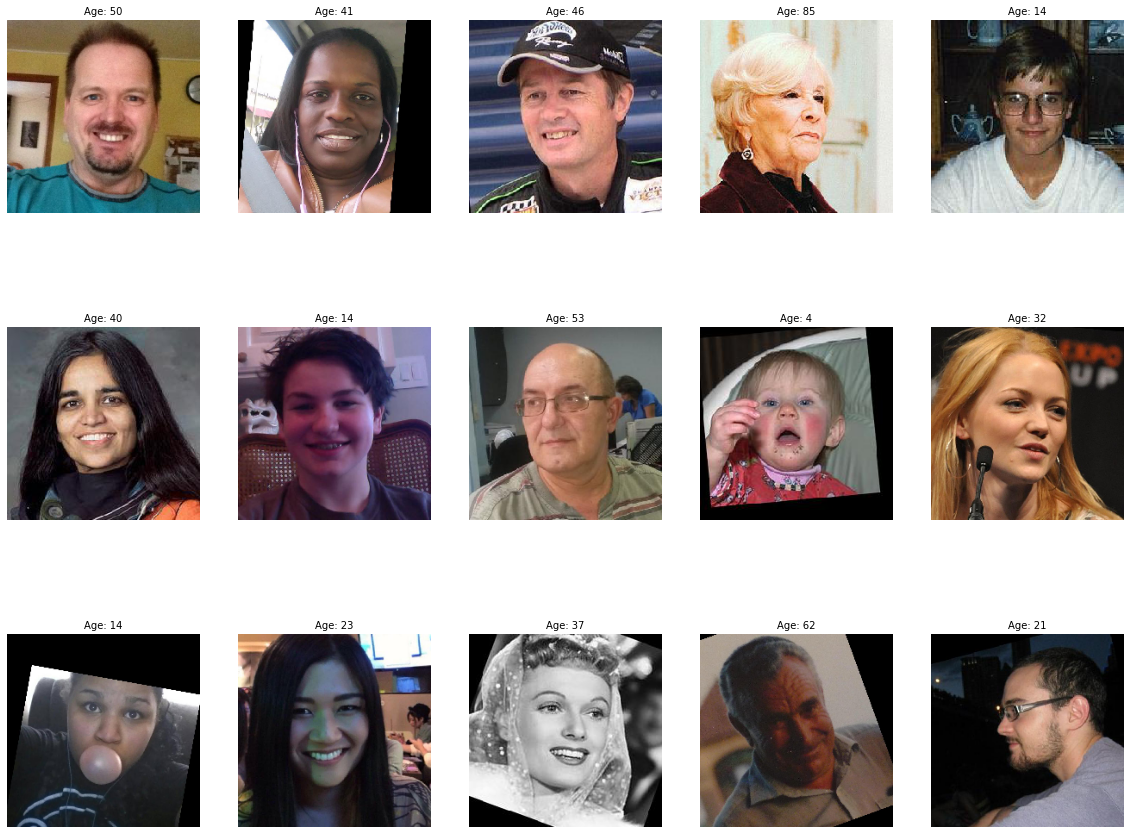

In [5]:
fig, axs = plt.subplots(3, 5, figsize=(20, 16))
images, labels = next(overall_datagen)

for i in range(15):
    ax = axs[i//5, i%5]
    ax.imshow(images[i])
    ax.set_title(f'Age: {labels[i]}', fontsize=10)
    ax.axis('off')
plt.show();

Думаю, можно сказать, что метки расставлены верно, однако сообщения имеют не такое уж и хорошее качество

**В результате исследовательского анализа данных**:

- были определены особенности выборки
    - Большая часть людей находится в диапазоне 20-40 лет
    - Люди старше 70 редко появляются в выборке, как и дети в возрасте 8-13 лет
    - Присутствует больщой скачок в самом начале графика - большая разница в количестве подростков и детей
    - Присутсвуют скачки(возможно, усреднённые значения возраста)
    - Есть выбросы(людей старше 90 довольно мало)
- были представленные некоторые экземпляры выборки

## Обучение модели

Составим модель, которая будет предсказывать возраст человека, основываясь на его фото

```python

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    directory = path + 'final_files'
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.25
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_datagen_flow

def load_test(path):
    directory = path + 'final_files'
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',               
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',          
        subset='validation',
        seed=12345
    )

    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    backbone.trainial = False

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')
    ])


    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['mae']
    )

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
       
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model

```

Так, было создано 4 функции, которые загружают данные, создают модель и обучают её.

Пришло время обучить нейросеть

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Epoch 1/8
356/356 - 80s - loss: 199.2540 - mae: 10.2508 - val_loss: 784.9345 - val_mae: 23.0420
Epoch 2/8
356/356 - 39s - loss: 84.9629 - mae: 7.0028 - val_loss: 174.3916 - val_mae: 9.6578
Epoch 3/8
356/356 - 39s - loss: 57.7921 - mae: 5.8056 - val_loss: 81.5531 - val_mae: 6.8391
Epoch 4/8
356/356 - 39s - loss: 41.0567 - mae: 4.8985 - val_loss: 78.6712 - val_mae: 6.6622
Epoch 5/8
356/356 - 39s - loss: 34.2107 - mae: 4.4521 - val_loss: 71.5778 - val_mae: 6.2654
Epoch 6/8
356/356 - 39s - loss: 24.3181 - mae: 3.7601 - val_loss: 79.2628 - val_mae: 6.5339
Epoch 7/8
356/356 - 39s - loss: 20.3683 - mae: 3.4601 - val_loss: 70.2537 - val_mae: 6.1792
Epoch 8/8
356/356 - 39s - loss: 16.2559 - mae: 3.0710 - val_loss: 64.4373 - val_mae: 5.9596

```

Отличный результат!

## Анализ обученной модели

Итак, какие выводы можно сделать на основе данных, полученных в ходе обучения:

- В качестве архитектруры нейронной сети использовался ResNet50(бэкбон + голова), обученный на ImageNet
- Модель обучалась на 5694 изображении, а валидация включала в себя 1897 картинок
- Модель сильно улучшилась за первые 3 эпохи, однако потом просто "cтояла на месте"
- MAE обученной модели составил лишь 5.9 единиц в сравнение с 23 в начале обучения
- Модель переобучилась(метрики train_loss и val_loss различаются в 4 раза)

Параметры обучения: batch_size=16, optimizator=Adam(learning_rate=0.0001), backbone.trainial=False, epochs=8

## Общий вывод

В результате обучения была получена модель(в основе которой лежит ResNet50), которая может определить возраст человека по картинке, в среднем ошибаясь на 5.9 лет. Причём, из-за специфики выборки(неравномерного распределения возраста), модель лучше предсказывает возраст людей от 20 до 40 лет, в то время как определение возраста ребёнка от 8 до 13 лет или пожилых(от 80 лет) является более трудной задачей

Таким образом, полученная модель хорошо подходит для предложения товаров конкретным возрастным группам, однако она всё ещё недостаточно хороша для контроля добросовестности кассиров при продаже алкоголя.

Для получения более точных результатов нужно больше данных(предпочтительно о подростках и пожилых)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы